In [9]:
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import swan
from importlib import reload
reload(swan)

# swan defaults
ny = 10
nx = 10

n = nx * ny
nsigma = 4
ntheta = 3 # full is ntheta * ntheta
σscale = 'log'

# load input data
wd = os.path.join('..')
datadir = os.path.join(wd, "data_temp")
u10 = np.load(os.path.join(datadir, "speed.npz"))['array'][:ny, :nx]
theta = np.load(os.path.join(datadir, "direction.npz"))['array'][:ny, :nx]
swh = np.load(os.path.join(datadir, "sig_waves.npz"))['array'][:ny, :nx]
bathy = np.load(os.path.join(datadir, "bathymetry.npz"))['array'][:ny, :nx]
land = [bathy < 0]
bathy[bathy < 0] = 1e-5 # check correct solution here later

dx = np.load(os.path.join(datadir, "bathymetry.npz"))['mesh'].item()
dy = dx

# redo in case nx or ny out of bounds
ny, nx = u10.shape
n = nx * ny
dims = [ntheta, nsigma, ny, nx]

# initialise list of sweeps
M = 4
sweeps = [{'id': m} for m in range(M)]

# spectral grid
sigmas, dsigma = swan.frequency_grid(nsigma, scale=σscale)
sweeps[0]['thetas'] = np.linspace(0, np.pi/2, ntheta)
sweeps[1]['thetas'] = np.linspace(np.pi/2, np.pi, ntheta)
sweeps[2]['thetas'] = np.linspace(-np.pi/2, -np.pi, 3)
sweeps[3]['thetas'] = np.linspace(0, -np.pi/2, 3)

stepθ = 1
stepσ = ntheta
stepy = stepσ * nsigma
stepx = stepy * ny

## Sweep $n$

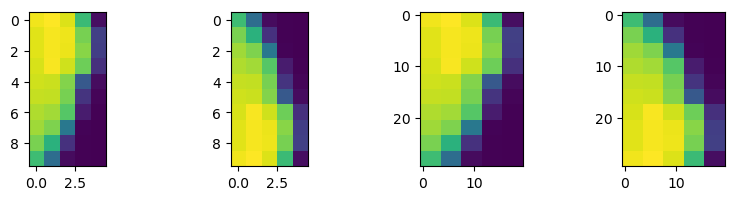

In [10]:
# check everything is being flipped correctly
id = 3
thetas = sweeps[id]['thetas']
sweep = sweeps[id]['id']

fig, axs = plt.subplots(1, 4, figsize=(10, 2))
axs[0].imshow(bathy)
axs[1].imshow(swan.sweep_flip(bathy, sweep))
_, _, H  = np.meshgrid(thetas, sigmas, bathy.ravel(order=swan.order), indexing='ij')
axs[2].imshow(swan.flattened_meshgrid(H, dims, which='z'))
_, _, H  = np.meshgrid(thetas, sigmas, swan.sweep_flip(bathy, sweep).ravel(order=swan.order), indexing='ij')
axs[3].imshow(swan.flattened_meshgrid(H, dims, which='z'));

In [16]:
dt = 1

for sweep in sweeps:
    thetas = sweep['thetas']
    sweep['dtheta'] = abs(thetas[1] - thetas[0])

    # make meshgrids for all the inputs
    *_, H  = np.meshgrid(thetas, sigmas, swan.sweep_flip(bathy, sweep['id']).ravel(order=swan.order), indexing='ij')
    *_, θm  = np.meshgrid(thetas, sigmas, swan.sweep_flip(theta, sweep['id']).ravel(order=swan.order), indexing='ij')
    θ, Σ, U10  = np.meshgrid(thetas, sigmas, swan.sweep_flip(u10, sweep['id']).ravel(order=swan.order), indexing='ij')
    
    
    # initial energy distribution
    Ef = swan.spectrum_pm(Σ, U10)
    fpeak = swan.peak_frequency_pm(U10) / (2 * np.pi)
    D = swan.cos2_model(θ, θm)
    E = Ef * D
    N = E / Σ

    # velocities
    K = swan.inverse_dispersion_approx(Σ, H)
    c = swan.phase_speed(K, Σ)
    cg = swan.group_velocity(K, H, Σ)
    cx, cy = swan.spatial_group_velocity(cg, θ)
    cθ = swan.directional_velocity(θ, c, cg, stepx, stepy, dx, dy)
    # cσ = ...

    # update matrices
    A_geo = swan.bsbt_matrix(stepx, stepy, cx, cy, dx, dy)
    A_spectral = swan.theta_block_matrix(cθ, stepθ)
    A = A_spectral + A_geo
    I = np.eye(ntheta * nsigma * ny * nx)
    Ainv = np.linalg.inv(I + dt * A)
    
    # add to sweep data
    sweep['θ'], sweep['Σ'] = θ, Σ
    sweep['N0'] = N
    sweep['A'] = Ainv

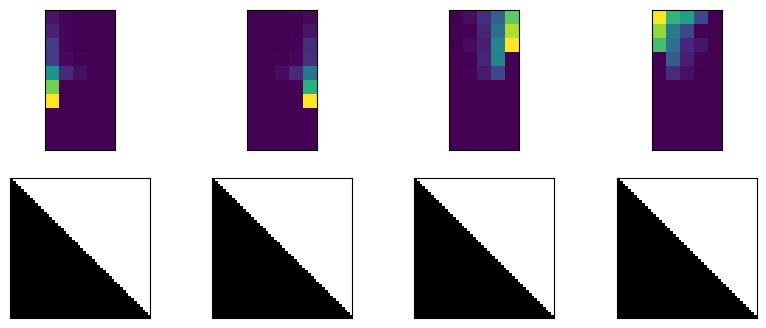

In [17]:
fig, axs = plt.subplots(2, 4, figsize=(10, 4))
for ax, sweep in zip(axs[0, :], sweeps):
    ax.imshow(sweep['N0'][1, 1, :].reshape([ny, nx], order=swan.order))
    ax.set_xticks([])
    ax.set_yticks([])
for ax, A in zip(axs[1, :], sweeps):
    ax.spy(sweep['A'])
    ax.set_xticks([])
    ax.set_yticks([])

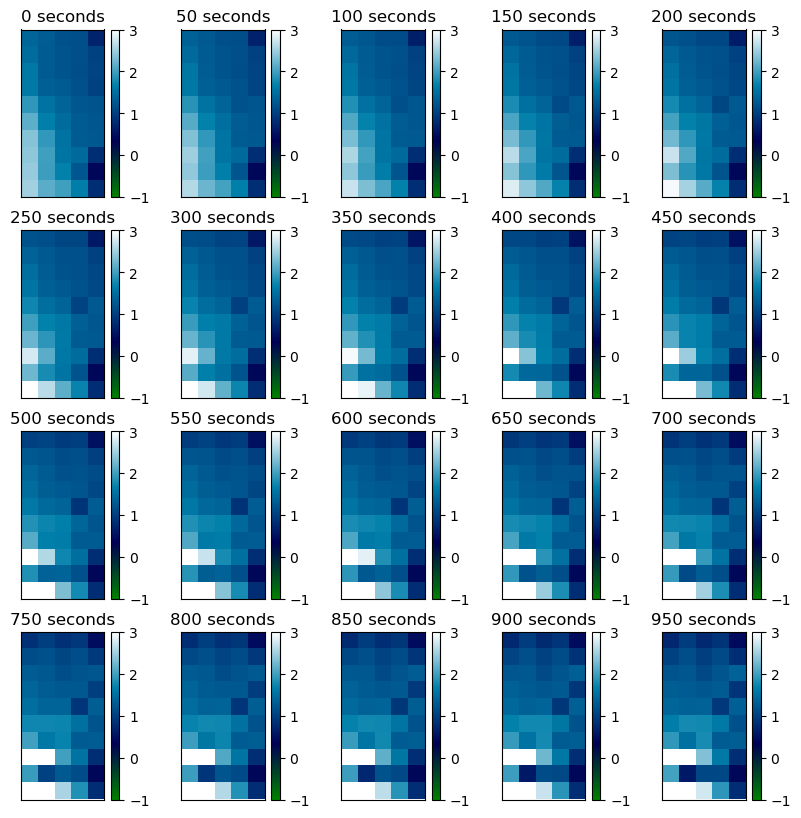

In [18]:
T = 1000

fig, axs = plt.subplots(4, 5, figsize=(10, 10))
vmin, vmax = -1, 3
axs = axs.ravel()
nax = len(axs)
Σ_full = np.concatenate([sweep['Σ'] for sweep in sweeps], axis=0)
dtheta = sweeps[0]['dtheta']

# set up initial conditions
for sweep in sweeps:
    sweep['N'] = sweep['N0']

i = 0
for t in range(T):
    for sweep in sweeps:
        N1 = sweep['A'] @ sweep['N'].ravel(order=swan.order)
        E1 = swan.energy_density(N1, sweep['Σ']).reshape(dims, order=swan.order)
        E1 = swan.eliminate_negative_energies(E1, sweep['dtheta'], ntheta)
        N1 = swan.action_density(E1, sweep['Σ']).ravel(order=swan.order)
        sweep['N'] = N1

    # plot results
    if t % int(T / 20) == 0:
        N1 = [sweep['N'].reshape(dims, order=swan.order) for sweep in sweeps]
        N1 = [swan.sweep_flip(N, sweep_id) for sweep_id, N in enumerate(N1)]
        N1 = np.concatenate([N for N in N1], axis=0)

        E1 = swan.energy_density(N1, Σ_full)
        Hs1 = swan.significant_wave_height(E1, dtheta, dsigma)

        im = axs[i].imshow(Hs1, cmap='ocean', vmin=vmin, vmax=vmax)
        plt.colorbar(im)
        axs[i].set_title(f"{t*dt} seconds")
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        i += 1